[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/034_rnn_intro/rnn_intro.ipynb)

# Redes Neuronales Recurrentes

# DATASET

El archivo principal es traffic.csv, y contiene datos de tráfico de vehículos en diferentes días y horas, con el objetivo de predecir la congestión del tráfico.

🔑 Columnas principales

Según la descripción en Kaggle y el propio CSV:

ID → Identificador único de la fila.

DateTime → Marca temporal (día y hora).

Formato: YYYY-MM-DD HH:MM:SS.

Permite trabajar con series temporales.

Junction → Intersección (cruce de calles).

Valores enteros (1, 2, 3, 4).

Indica en qué cruce se está midiendo el tráfico.

Vehicles → Número de vehículos que pasaron en ese intervalo. 🚗

Es la variable objetivo a predecir.

Tipo: entero (0, 1, 2, …).

📌 Interpretación para tu modelo (RNN / MLP)

Entrada → Una secuencia de valores de tráfico (Vehicles) en el tiempo.

Posibles features adicionales:

Junction → para distinguir entre cruces.

DateTime → se puede transformar en hora del día, día de la semana, etc.

Salida (target) → Predicción de Vehicles en el futuro (ej. 1 hora adelante).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# -------------------------
# Librerías
# -------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

# -------------------------
# Configuración
# -------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# Ruta a tu archivo en Google Drive
CSV_PATH = "/content/drive/MyDrive/Inteligencia Artificial 2/TraficDataSet/traffic.csv"
JUNCTION = 1               # analizamos Junction 1
SEQ_LEN = 24               # 24 horas de historial
HORIZON = 1                # predecir la siguiente hora
BATCH_SIZE = 128
EPOCHS = 30
LR = 1e-3

In [ ]:
# -------------------------
# Cargar datos
# -------------------------
df = pd.read_csv(CSV_PATH)
df["DateTime"] = pd.to_datetime(df["DateTime"])
df = df[df["Junction"] == JUNCTION].sort_values("DateTime").reset_index(drop=True)

print("Rango temporal:", df["DateTime"].min(), "→", df["DateTime"].max())
print("Total de registros:", len(df))


Rango temporal: 2015-11-01 00:00:00 → 2017-06-30 23:00:00
Total de registros: 14592


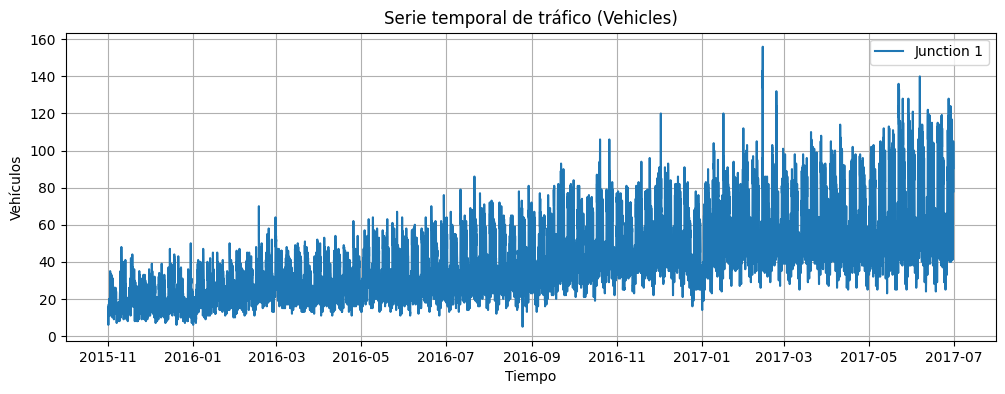

In [ ]:
# -------------------------
# Visualización inicial
# -------------------------
plt.figure(figsize=(12,4))
plt.plot(df["DateTime"], df["Vehicles"], label=f"Junction {JUNCTION}")
plt.title("Serie temporal de tráfico (Vehicles)")
plt.xlabel("Tiempo")
plt.ylabel("Vehículos")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:

# -------------------------
# Dataset de ventanas
# -------------------------
class TimeSeriesDataset(Dataset):
    def __init__(self, series, seq_len, horizon, scaler=None, fit_scaler=False):
        self.seq_len = seq_len
        self.horizon = horizon
        series = series.reshape(-1,1).astype(np.float32)

        if scaler is None:
            scaler = StandardScaler()
            fit_scaler = True

        self.scaler = scaler
        if fit_scaler:
            self.scaler.fit(series)
        x = self.scaler.transform(series).astype(np.float32)

        self.X, self.y = [], []
        for i in range(seq_len, len(x)-horizon+1):
            self.X.append(x[i-seq_len:i])
            self.y.append(x[i:i+horizon])
        self.X, self.y = np.array(self.X), np.array(self.y)

    def __len__(self): return len(self.X)
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx]), torch.from_numpy(self.y[idx])

In [ ]:
# -------------------------
# Train / Val / Test split
# -------------------------
values = df["Vehicles"].values
n = len(values)
n_train = int(0.7*n)
n_val = int(0.15*n)

train_values = values[:n_train]
val_values = values[n_train:n_train+n_val]
test_values = values[n_train+n_val:]

scaler = StandardScaler().fit(train_values.reshape(-1,1))
ds_train = TimeSeriesDataset(train_values, SEQ_LEN, HORIZON, scaler, False)
ds_val   = TimeSeriesDataset(val_values,   SEQ_LEN, HORIZON, scaler, False)
ds_test  = TimeSeriesDataset(test_values,  SEQ_LEN, HORIZON, scaler, False)

dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True)
dl_val   = DataLoader(ds_val,   batch_size=BATCH_SIZE, shuffle=False)
dl_test  = DataLoader(ds_test,  batch_size=BATCH_SIZE, shuffle=False)

print("Tamaños:", len(ds_train), len(ds_val), len(ds_test))

Tamaños: 10190 2164 2166


In [ ]:

# -------------------------
# Modelos
# -------------------------
class MLP(nn.Module):
    def __init__(self, seq_len, horizon):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(seq_len, 64),
            nn.ReLU(),
            nn.Linear(64, horizon)
        )
    def forward(self, x):
        return self.fc(x).unsqueeze(-1)

class SimpleRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1, horizon=1):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, horizon)
    def forward(self, x):
        out, _ = self.rnn(x)
        last = out[:, -1, :]
        return self.fc(last).unsqueeze(-1)

In [ ]:
# -------------------------
# Función de entrenamiento
# -------------------------
def train_model(model, dl_train, dl_val, epochs=20):
    model = model.to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=LR)
    loss_fn = nn.MSELoss()
    history = {"train": [], "val": []}

    for ep in range(epochs):
        model.train()
        train_losses = []
        for xb,yb in dl_train:
            xb,yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            yhat = model(xb)
            loss = loss_fn(yhat, yb)
            loss.backward()
            opt.step()
            train_losses.append(loss.item())
        train_loss = np.mean(train_losses)

        model.eval()
        val_losses = []
        with torch.no_grad():
            for xb,yb in dl_val:
                xb,yb = xb.to(DEVICE), yb.to(DEVICE)
                yhat = model(xb)
                loss = loss_fn(yhat, yb)
                val_losses.append(loss.item())
        val_loss = np.mean(val_losses)

        history["train"].append(train_loss)
        history["val"].append(val_loss)
        print(f"Epoch {ep+1:02d} | Train {train_loss:.4f} | Val {val_loss:.4f}")

    return model, history

In [ ]:
def evaluate_model(model, dataloader, scaler):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for xb, yb in dataloader:
            xb, yb = xb.to(device), yb.to(device)   # mover al mismo device
            out = model(xb)
            preds.append(out.cpu().numpy())   # a CPU para sklearn
            targets.append(yb.cpu().numpy())

    preds = np.concatenate(preds)
    targets = np.concatenate(targets)

    # ---- 👇 Aplanar en 2D o 1D para sklearn ----
    preds = preds.reshape(-1, 1)
    targets = targets.reshape(-1, 1)

    # Invertir el escalado
    preds = scaler.inverse_transform(preds)
    targets = scaler.inverse_transform(targets)

    # Calcular métricas
    mae = mean_absolute_error(targets, preds)
    rmse = np.sqrt(mean_squared_error(targets, preds))

    return preds, targets, mae, rmse


In [ ]:
# -------------------------
# Baseline Naïve
# -------------------------
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

naive_preds = test_values[SEQ_LEN-1:-HORIZON]  # último valor = predicción
naive_targets = test_values[SEQ_LEN:]

mae_naive = mean_absolute_error(naive_targets, naive_preds)
rmse_naive = np.sqrt(mean_squared_error(naive_targets, naive_preds))  # corregido

print("\nBaseline Naïve → MAE:", mae_naive, "RMSE:", rmse_naive)



Baseline Naïve → MAE: 6.469529085872576 RMSE: 8.407417689566332


In [ ]:
# -------------------------
# 1. Configurar device (GPU en Colab si está disponible)
# -------------------------
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

# -------------------------
# 2. Entrenar y evaluar modelos
# -------------------------
results = []

# MLP
mlp = MLP(SEQ_LEN, HORIZON).to(device)   # 👈 modelo al device (GPU/CPU)
mlp, hist_mlp = train_model(mlp, dl_train, dl_val, EPOCHS)
preds_mlp, targets_mlp, mae_mlp, rmse_mlp = evaluate_model(mlp, dl_test, scaler)
results.append(("MLP", mae_mlp, rmse_mlp))

# RNN
rnn = SimpleRNN(input_size=1, hidden_size=64, num_layers=1, horizon=HORIZON).to(device)  # 👈 modelo al device
rnn, hist_rnn = train_model(rnn, dl_train, dl_val, EPOCHS)
preds_rnn, targets_rnn, mae_rnn, rmse_rnn = evaluate_model(rnn, dl_test, scaler)
results.append(("RNN", mae_rnn, rmse_rnn))


Usando dispositivo: cuda
Epoch 01 | Train 0.3176 | Val 0.3200
Epoch 02 | Train 0.1037 | Val 0.2080
Epoch 03 | Train 0.0757 | Val 0.1602
Epoch 04 | Train 0.0655 | Val 0.1421
Epoch 05 | Train 0.0602 | Val 0.1320
Epoch 06 | Train 0.0577 | Val 0.1250
Epoch 07 | Train 0.0557 | Val 0.1242
Epoch 08 | Train 0.0546 | Val 0.1201
Epoch 09 | Train 0.0533 | Val 0.1217
Epoch 10 | Train 0.0525 | Val 0.1155
Epoch 11 | Train 0.0518 | Val 0.1122
Epoch 12 | Train 0.0513 | Val 0.1135
Epoch 13 | Train 0.0505 | Val 0.1121
Epoch 14 | Train 0.0501 | Val 0.1129
Epoch 15 | Train 0.0499 | Val 0.1106
Epoch 16 | Train 0.0496 | Val 0.1088
Epoch 17 | Train 0.0489 | Val 0.1111
Epoch 18 | Train 0.0489 | Val 0.1089
Epoch 19 | Train 0.0487 | Val 0.1102
Epoch 20 | Train 0.0489 | Val 0.1075
Epoch 21 | Train 0.0478 | Val 0.1064
Epoch 22 | Train 0.0473 | Val 0.1065
Epoch 23 | Train 0.0473 | Val 0.1078
Epoch 24 | Train 0.0475 | Val 0.1105
Epoch 25 | Train 0.0471 | Val 0.1049
Epoch 26 | Train 0.0467 | Val 0.1056
Epoch 27 | Tr

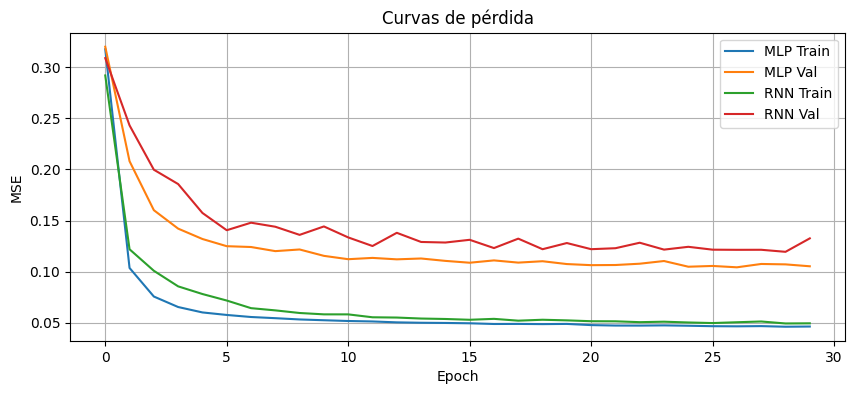

In [ ]:
# Baseline
results.append(("Naïve", mae_naive, rmse_naive))

# -------------------------
# Gráficas de pérdidas
# -------------------------
plt.figure(figsize=(10,4))
plt.plot(hist_mlp["train"], label="MLP Train")
plt.plot(hist_mlp["val"], label="MLP Val")
plt.plot(hist_rnn["train"], label="RNN Train")
plt.plot(hist_rnn["val"], label="RNN Val")
plt.title("Curvas de pérdida")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.show()


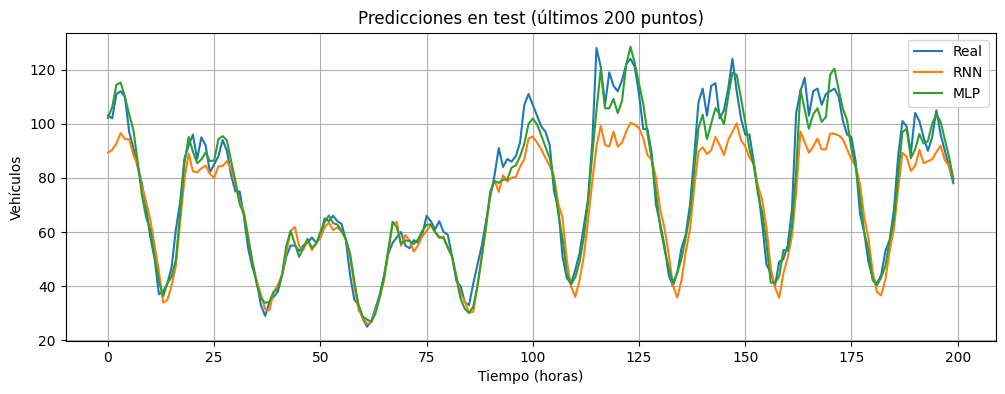

In [ ]:
# Comparación de predicciones
# -------------------------
show_last = 200
plt.figure(figsize=(12,4))
plt.plot(targets_rnn[-show_last:,0], label="Real")
plt.plot(preds_rnn[-show_last:,0], label="RNN")
plt.plot(preds_mlp[-show_last:,0], label="MLP")
plt.title(f"Predicciones en test (últimos {show_last} puntos)")
plt.xlabel("Tiempo (horas)")
plt.ylabel("Vehículos")
plt.legend()
plt.grid(True)
plt.show()



  Modelo       MAE      RMSE
0    MLP  4.108461  5.780517
1    RNN  6.381217  8.814262
2  Naïve  6.469529  8.407418


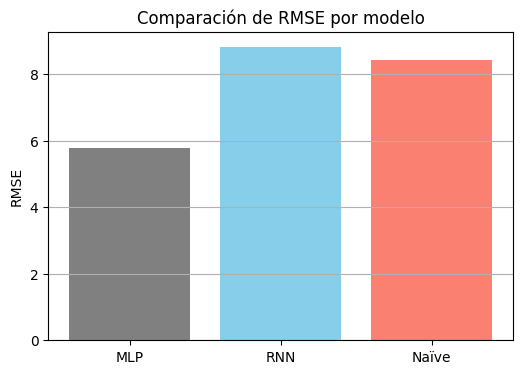

In [ ]:
# -------------------------
# Comparación de métricas
# -------------------------
res_df = pd.DataFrame(results, columns=["Modelo","MAE","RMSE"])
print(res_df)

plt.figure(figsize=(6,4))
plt.bar(res_df["Modelo"], res_df["RMSE"], color=["gray","skyblue","salmon"])
plt.title("Comparación de RMSE por modelo")
plt.ylabel("RMSE")
plt.grid(axis="y")
plt.show()
